In [1]:
import Rible as RB
include(joinpath(pathof(RB),"../../yard/nonsmooth.jl"))
include(joinpath(pathof(RB),"../../test/vis.jl"))
scalefactor = 2
include(joinpath(pathof(RB),"../../examples/robots/pointmass.jl"));

ground plane

In [2]:
θ=0.0
ground_plane = RB.StaticContactSurfaces(
    [
        RB.HalfSpace([-tan(θ),0,1],zeros(3)),
    ]
);

time

In [3]:
tspan = (0.0,1.5)
h = 1e-3;

parameters and initial conditions

In [4]:
restitution_coefficients = [0.5]
v0s = [1.0];

pointmass

In [5]:
pm = new_pointmass(;
    e = restitution_coefficients[1],
    μ=0.1,
    origin_velocity = [v0s[1],0,0]
);

frictional contact dynamics problem

In [6]:
prob = RB.DynamicsProblem(
    pm,
    ground_plane,
    RB.RestitutionFrictionCombined(
        RB.NewtonRestitution(),
        RB.CoulombFriction(),
    )
);

simulate

In [7]:
RB.solve!(
    prob,
    RB.DynamicsSolver(
        RB.Zhong06(),
        RB.InnerLayerContactSolver(
            RB.InteriorPointMethod()
        )
    );
    tspan,dt=h,
    ftol=1e-14,
    maxiters=50,
    exception=false
);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


visualize

[ Info: Saving to pointmass_bouncing.png


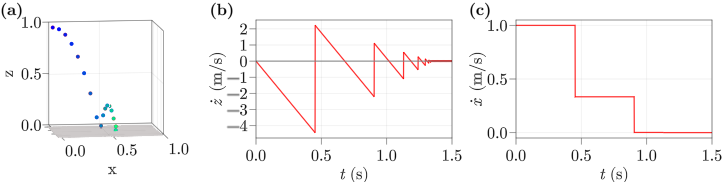

In [8]:
GM.activate!(;scalefactor); with_theme(theme_pub;
        size = (0.8tw,0.2tw),
        figure_padding = (0,fontsize,0,0),
        Axis3 = (
            azimuth = 4.575530633326986,
            elevation = 0.13269908169872408
        ),
        color = :red,
        palette = (
            color = [:red, :blue],
        ),
        Scatter = (
            markersize = 2.5,
            color = :red,
            cycle = [:color ],
        )
    ) do
    bot = pm
    fig = Figure()
    gd1 = fig[1,1] = GridLayout()
    gd2 = fig[1,2] = GridLayout()
    colsize!(fig.layout,2,Fixed(0.5tw))
    steps = 1:60:1000
    cg = cgrad(:winter, length(steps), categorical = true)
    plot_traj!(bot;
        doslide=false,
        AxisType = Axis3,
        fig = gd1,
        # gridsize=(1,4),
        xlims=(-1e-3,1.0),
        ylims=(-0.4,0.4),
        zlims=(-1e-3,1.0),
        showinfo =false,
        showmesh=false,
        showwire=false,
        showlabels=false,
        showcables=false,
        showpoints=false,
        showtitle=false,
        sup! = (ax,tgob,sgi) -> begin
            RB.hidey(ax)
            for (istep,step) in enumerate(steps)
                suptg = deepcopy(bot.structure)
                suptg.state.system.q .= bot.traj.q[step]
                RB.update!(suptg)
                RB.viz!(ax,Observable(suptg);
                    showlabels=false,
                    showmesh=false,
                    showcables=false,
                    showwire=false,
                    showpoints=true,
                    pointcolor=cg[istep]
                )
            end
        end
        # figname="pointmass_e05_v00",
        # figname="pointmass_e05_v10"
    )
    Label(gd1[1,1,TopLeft()],
        rich("($(alphabet[1]))",font=:bold)
    )
    (;t) = bot.traj
    ax1 = Axis(gd2[1,1], xlabel = tlabel, ylabel = L"\dot{z}~(\mathrm{m/s})")
    vp1 = RB.get_velocity!(bot,1,1)
    lines!(ax1,t,vp1[3,:])
    xlims!(ax1,t[begin],t[end])
    # ylims!(ax1,-6,6)
    Label(gd2[1,1,TopLeft()],
        rich("($(alphabet[2]))",font=:bold)
    )
    hlines!(ax1,[0],color=:gray)
    ax2 = Axis(gd2[1,2], xlabel = tlabel, ylabel = L"\dot{x}~(\mathrm{m/s})")
    # me = RB.mechanical_energy!(bot)
    # lines!(ax2,t,me.E)
    lines!(ax2,t,vp1[1,:])
    xlims!(ax2,t[begin],t[end])
    # ylims!(ax2,-1,11)
    # ax2.yticks = [0,0.3,0.7,1.0]
    # ax2.xticks = collect(1:xtickmaxs[botid])
    Label(gd2[1,2,TopLeft()],
        rich("($(alphabet[3]))",font=:bold)
    )
    colgap!(fig.layout,1,0)
    savefig(fig,"pointmass_bouncing")
    fig
end

inclined plane

In [9]:
θ = 15 |> deg2rad
inclined_plane = RB.StaticContactSurfaces(
    [
        RB.HalfSpace([-tan(θ),0,1],zeros(3)),
    ]
);

initial conditions

In [10]:
origin_position = [0.0,0,-1e-7]
origin_velocity = [2.0cos(θ),0,2.0sin(θ)]
# origin_velocity = [0,-2.0,0]

3-element Vector{Float64}:
 1.9318516525781366
 0.0
 0.5176380902050415

analytical solutions

In [11]:
g = 9.81
μ=0.3
vo = norm(origin_velocity)
a = -μ*g*cos(θ)-g*sin(θ)
# μ*g*cos(θ)-g*sin(θ)
tf = -vo/a
d(t) = vo*min(t,tf)+1/2*a*min(t,tf)^2

d (generic function with 1 method)

simulation

In [12]:
tspan = (0.0,0.6)
pm = new_pointmass(;e=0.0, μ, origin_position, origin_velocity)

prob = RB.DynamicsProblem(
    pm,
    inclined_plane,
    RB.RestitutionFrictionCombined(
        RB.NewtonRestitution(),
        RB.CoulombFriction(),
    )
)
RB.solve!(
    prob,
    RB.DynamicsSolver(
        RB.Zhong06(),
        RB.InnerLayerContactSolver(
            RB.InteriorPointMethod()
        )
    );
    tspan,dt=1e-3,ftol=1e-14,maxiters=50,exception=false
);

post processing

In [13]:
rp1 = RB.get_trajectory!(pm,1,1)
ṙp1 = RB.get_velocity!(pm,1,1)
dp1 = rp1.u .|> norm
vl1 = [u ⋅ normalize(origin_velocity) for u in ṙp1];

visualize

findmax(dp1) = (0.3716269978800062, 373)
(extrema(dp1), extrema(vl1)) = ((1.0e-7, 0.3716269978800062), (0.00012068488939566885, 2.0))
[ Info: Saving to pointmass_sliding.png


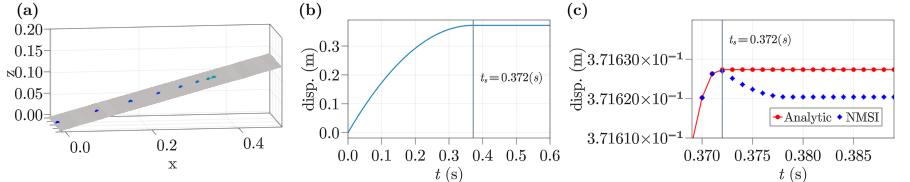

In [14]:
GM.activate!(;scalefactor); with_theme(theme_pub;
        size = (1tw,0.2tw),
        figure_padding = (fontsize,fontsize,0,0),
        Axis3 = (
            azimuth = 4.575530633326984,
            elevation = 0.16269908169872405,
            # zlabelvisible = false,
            # yticklabelsvisible = false,
        ),
        Scatter = (
            markersize = 3,
        )
    ) do
    steps = 1:50:600
    cg = cgrad(:winter, length(steps), categorical = true)
    bot = pm
    (;t) = bot.traj
    fig = Figure()
    gd1 = fig[1,1] = GridLayout()
    gd2 = fig[1,2] = GridLayout()
    Label(gd1[1,1,TopLeft()],
        rich("($(alphabet[1]))",font=:bold)
    )
    plot_traj!(bot;
        doslide=false,
        AxisType=Axis3,
        fig = gd1,
        xlims=(-8e-3,0.5),
        ylims=(-0.1,0.1),
        zlims=(-8e-3,0.2),
        showinfo =false,
        showmesh=false,
        showwire=false,
        showlabels=false,
        showcables=false,
        showpoints=false,
        showtitle=false,
        ground=inclined_plane,
        sup! = (ax,tgob,sgi) -> begin
            RB.hidey(ax)
            for (istep,step) in enumerate(steps)
                suptg = deepcopy(bot.structure)
                suptg.state.system.q .= bot.traj.q[step]
                RB.update!(suptg)
                RB.viz!(ax,Observable(suptg);
                    showlabels=false,
                    showmesh=false,
                    showcables=false,
                    showwire=false,
                    showpoints=true,
                    pointcolor=cg[istep]
                )
            end
        end,
    )
    ax1 = Axis(gd2[1,1], xlabel = tlabel, ylabel = "disp. (m)")
    Label(gd2[1,1,TopLeft()],
        rich("($(alphabet[2]))",font=:bold)
    )
    ax2 = Axis(gd2[1,2], xlabel = tlabel, ylabel = "disp. (m)")
    Label(gd2[1,2,TopLeft()],
        rich("($(alphabet[3]))",font=:bold)
    )
    rp1 = RB.get_trajectory!(bot,1,1)
    ṙp1 = RB.get_velocity!(bot,1,1)
    dp1 = rp1.u .|> norm
    vl1 = ṙp1.u .|> norm
    @myshow findmax(dp1)
    stopstep = RB.time2step(tf,t)
    lines!(ax1,t,dp1)
    xlims!(ax1,0,0.6)
    scatterlines!(ax2,t,d.(t),color=:red,label="Analytic")
    scatter!(ax2,t,dp1,color=:blue,marker=:diamond,label="NMSI")
    axislegend(ax2;position=:rb,orientation=:horizontal,)
    xlims!(ax2,0.369,0.389)
    ylims!(ax2,3.7161e-1,3.7164e-1)
    vlines!(ax1,t[stopstep])
    vlines!(ax2,t[stopstep])
    text!(ax1,latexstring("t_s=0.372(s)"),
        position = (tf+0.02, 0.19),
        fontsize = 6,
        align = (:left, :center)
    )
    text!(ax2,latexstring("t_s=0.372(s)"),
        position = (tf+0.001, 3.71635e-1),
        fontsize = 6,
        align = (:left, :center),
        justification = :left
    )
    @show extrema(dp1), extrema(vl1)
    colsize!(fig.layout,2,Relative(0.7))
    colgap!(fig.layout,1,-fontsize)
    savefig(fig,"pointmass_sliding")
    DataInspector(fig)
    fig
end

convergence analysis

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


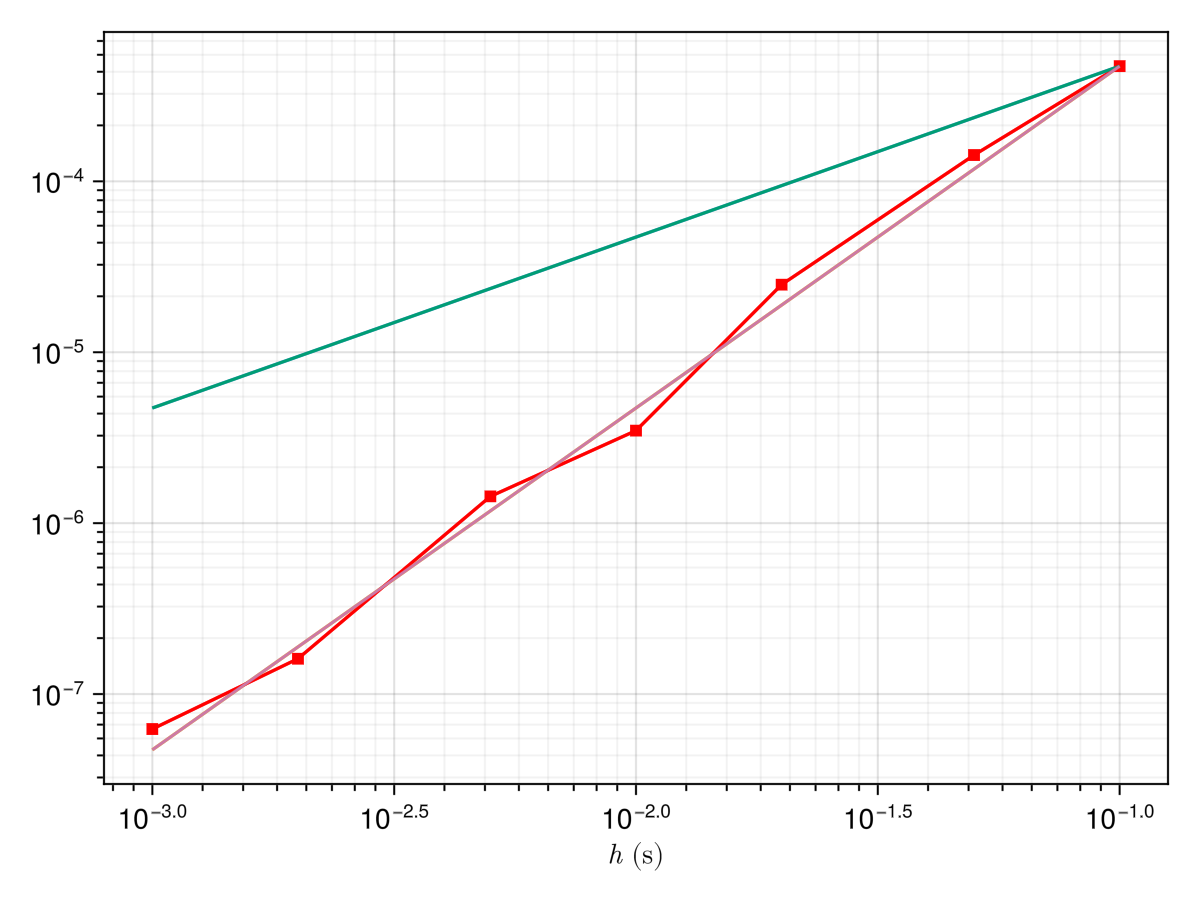

In [15]:
dts = [1e-1,5e-2,2e-2,1e-2,5e-3,2e-3,1e-3,1e-5]
pm_dts = [
    RB.solve!(
        RB.DynamicsProblem(
            deepcopy(pm),
            inclined_plane,
            RB.RestitutionFrictionCombined(
                RB.NewtonRestitution(),
                RB.CoulombFriction(),
            )
        ),
        RB.DynamicsSolver(
            solver,
            RB.InnerLayerContactSolver(
                RB.InteriorPointMethod()
            );
            checkpersist=false
        );
        tspan,dt,ftol=1e-14,maxiters=50,exception=true
    ).prob.bot
    for dt in dts, solver in (RB.Zhong06(), RB.Moreau(0.5))
]
pm_dts[end,1] = pm_dts[end,2]
fig = Figure()
ax = Axis(fig[1,1])
_,err_avg = RB.get_err_avg(pm_dts[:,1];bid=1,pid=1,di=3)
plot_convergence_order!(ax,dts[begin:end-1],err_avg)
_,err_avg = RB.get_err_avg(pm_dts[:,2];bid=1,pid=1,di=3)
plot_convergence_order!(ax,dts[begin:end-1],err_avg)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*